# Gene constraint pLI analysis
- gencode and exac: autosomal protein-coding genes, unique gene name-ENSG
- fetal, gtex, pec perm eGenes; non-eGene restricting to tested genes
- higher pLI, more intolerent

In [1]:
library(data.table)
library(tidyverse)
library(ggsignif)
library("ggsci")

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘hms’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



### Read genomAD ExAC gene constraint
- info for 18225 unique genes, some have alternative cnv related info

In [2]:
exac <- fread("/u/project/gandalm/shared/refGenomes/gnomAD_ExAC/forweb_cleaned_exac_r03_march16_z_data_pLI_CNV-final.txt.gz", 
              data.table = F)
head(exac)

,transcript,gene,chr,n_exons,tx_start,tx_end,bp,mu_syn,mu_mis,mu_lof,...,exp_syn,exp_mis,exp_lof,syn_z,mis_z,lof_z,pLI,n_cnv,exp_cnv,cnv_z
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENST00000263100.3,A1BG,19,8,58858387,58864803,1488,1.226238e-05,2.313709e-05,1.001499e-06,...,104.72874,199.8078,12.301382,1.07397341,1.0314310,1.2148449,9.064924e-05,3,3.609902,0.1114399
2,ENST00000373995.3,A1CF,10,11,52566488,52610547,1785,6.398919e-06,1.544409e-05,1.898738e-06,...,76.69884,178.5860,25.936584,-0.65840371,0.3874580,3.2942701,3.619701e-03,NaN,NaN,NaN
3,ENST00000318602.7,A2M,12,36,9220418,9268445,4425,1.762405e-05,4.048718e-05,3.983987e-06,...,187.60270,414.5167,51.706092,0.02727917,0.5169173,4.9188223,5.401149e-04,3,8.706319,0.8335034
4,ENST00000299698.7,A2ML1,12,35,8975247,9027607,4365,1.787013e-05,4.015104e-05,3.712316e-06,...,216.07566,467.0402,56.064599,-0.41854908,-0.7912401,1.8606843,1.329022e-22,63,11.846831,-2.2814308
5,ENST00000442999.3,A3GALT2,1,5,33772366,33786699,1023,1.013949e-05,1.867596e-05,7.352112e-07,...,83.27799,153.7933,8.016677,2.32862595,1.9638967,-0.3440241,6.503026e-07,70,2.768617,-3.6581477
6,ENST00000401850.1,A4GALT,22,1,43088895,43089957,1062,8.501714e-06,1.641234e-05,3.955250e-07,...,96.74529,186.3743,4.900477,0.61422759,1.1240807,1.2978961,1.115987e-01,2,1.082622,-0.2080141


In [3]:
dim(exac)
length(unique(exac$transcript))
length(unique(exac$gene))

[1] 18282    23

[1] 18225

[1] 18225

In [4]:
# duplicated gene entries differ in cnv related columns
exac <- exac %>% select(gene, pLI)
length(unique(exac$gene))

[1] 18225

In [5]:
exac <- exac[!duplicated(exac$gene),]

In [6]:
gencode <- fread("../../salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table = F)

In [7]:
gencode <- gencode %>% filter(V11 == "protein_coding", !V1 %in% c("chrM", "chrX", "chrY")) %>% select(ensg, V11, V12)

In [7]:
dim(gencode)
length(unique(gencode$V12)) # different ensg with same name, i.e. "TBCE"
length(unique(gencode$ensg))

[1] 19145     3

[1] 19125

[1] 19145

In [8]:
dup <- gencode[duplicated(gencode$V12),]
gencode <- gencode %>% filter(!V12 %in% dup$V12)
dim(gencode)

[1] 19105     3

In [9]:
head(exac)
dim(exac)

,gene,pLI,ensg,V11
,<chr>,<dbl>,<chr>,<chr>
1,A1BG,9.064924e-05,ENSG00000121410,protein_coding
2,A1CF,3.619701e-03,ENSG00000148584,protein_coding
3,A2M,5.401149e-04,ENSG00000175899,protein_coding
4,A2ML1,1.329022e-22,ENSG00000166535,protein_coding
5,A3GALT2,6.503026e-07,ENSG00000184389,protein_coding
6,A4GALT,1.115987e-01,ENSG00000128274,protein_coding


[1] 16353     4

In [44]:
# gencode <- gencode %>% inner_join(exac, by = c("ensg"))
# dim(gencode)

### fetal, GTEx, PEC eGenes

In [2]:
# fetal <- fread("../results/mixed_perm_90hcp/sig_pheno_info.txt", data.table = F)
fetal <- fread("../results/mixed_perm_90hcp/all_assoc_perm_info.txt", data.table = F)
gtex <- fread("/u/project/gandalm/shared/GenomicDatasets/GTEx/GTEx_Analysis_v8_eQTL/Brain_Cortex.v8.egenes.txt.gz", data.table = F)
pec <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_perm/PEC_geneQTL_perm_geneHCP100+gPCs20+AllMeta_assoc.txt.gz", data.table = F, fill = T)

In [3]:
gtex <- gtex %>% separate(gene_id, c("gene_ensg", "gene_version"), sep = "[.]", remove = FALSE)

In [4]:
fetal.sig <- fetal %>% filter(qval < 0.05)

In [5]:
gtex.sig <- gtex %>% filter(qval < 0.05)

In [6]:
pec.sig <- pec %>% filter(qval < 0.05)

In [21]:
dim(fetal.sig)
dim(gtex.sig)
dim(pec.sig)

[1] 10094    15

[1] 9082   35

[1] 16295    20

In [7]:
fetal_only <- as.data.frame(setdiff(unique(fetal.sig$pid), unique(c(gtex.sig$gene_ensg, pec.sig$pid))))
dim(fetal_only)

[1] 2488    1

In [17]:
# fetal_only <- fetal_only %>% left_join(gencode, by = c("gene" = "ensg")) %>% select(gene, V11, V12)
# write.table(fetal_only, "../results/mixed_perm_90hcp/fetal_only_eGene.tsv", col.names = F, row.names = F, quote = F, sep = "\t")

In [15]:
shared <- as.data.frame(intersect(unique(fetal.sig$pid), c(pec.sig$pid, gtex.sig$gene_ensg)))
dim(shared)

[1] 7606    1

In [16]:
adult_only <- as.data.frame(setdiff(c(pec.sig$pid, gtex.sig$gene_ensg), shared$`intersect(unique(fetal.sig$pid), c(pec.sig$pid, gtex.sig$gene_ensg))`))
dim(adult_only)

[1] 10792     1

In [17]:
colnames(fetal_only)[1] <- colnames(shared)[1] <- colnames(adult_only)[1] <- "gene"

In [18]:
fetal_only <- fetal_only %>% inner_join(exac, by = c("gene" = "ensg"))
shared <- shared %>% inner_join(exac, by = c("gene" = "ensg"))
adult_only <- adult_only %>% inner_join(exac, by = c("gene" = "ensg"))

In [19]:
dim(fetal_only)
dim(shared)
dim(adult_only)

[1] 576   4

[1] 4952    4

[1] 6352    4

In [20]:
non_egene <- exac %>% filter(!ensg %in% c(fetal.sig$pid, gtex.sig$gene_ensg, pec.sig$pid))
dim(non_egene)

[1] 4473    4

In [21]:
non_egene <- non_egene %>% filter(ensg %in% c(fetal$pid, pec$pid, gtex$gene_ensg))
dim(non_egene)

[1] 3136    4

In [22]:
non_egene <- non_egene %>% select(ensg, gene, pLI, V11)
colnames(non_egene) <- c("gene", "gene.y", "pLI", "V11")

In [23]:
df <- rbind(fetal_only, shared, adult_only, non_egene)
df$group <- c(rep("Fetal eGene", 576), rep("Shared", 4952), rep("Adult eGene", 6352), rep("non-eGene", 3136))
df$group <- factor(df$group, levels = c("Fetal eGene", "Shared", "Adult eGene", "non-eGene"))

In [35]:
wilcox.test(df[df$group == "Fetal eGene",'pLI'], df[df$group == "Shared",'pLI'], two.sided = TRUE)
wilcox.test(df[df$group == "Fetal eGene",'pLI'], df[df$group == "Adult eGene",'pLI'], two.sided = TRUE)
wilcox.test(df[df$group == "Fetal eGene",'pLI'], df[df$group == "non-eGene",'pLI'], two.sided = TRUE)


	Wilcoxon rank sum test with continuity correction

data:  df[df$group == "Fetal eGene", "pLI"] and df[df$group == "Shared", "pLI"]
W = 1736812, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  df[df$group == "Fetal eGene", "pLI"] and df[df$group == "Adult eGene", "pLI"]
W = 1891883, p-value = 0.1739
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  df[df$group == "Fetal eGene", "pLI"] and df[df$group == "non-eGene", "pLI"]
W = 921438, p-value = 0.4397
alternative hypothesis: true location shift is not equal to 0


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”


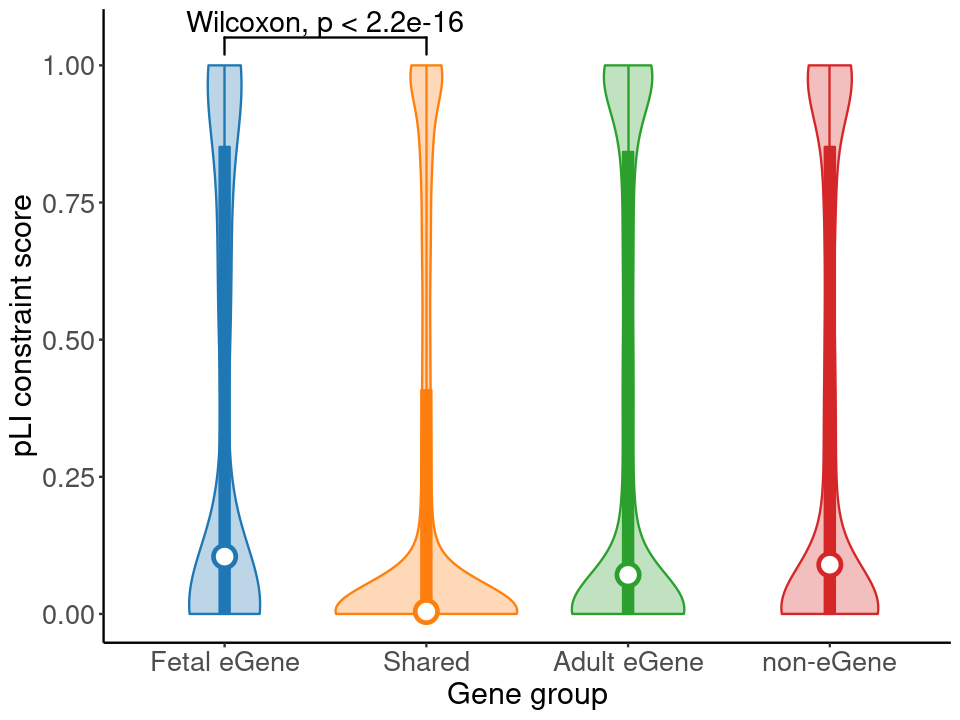

In [39]:
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(df, aes(x = group, y = pLI, fill = group, color = group)) +
geom_violin(alpha = 0.3, trim = TRUE) +
geom_boxplot(width = 0.05) +
labs(x = "Gene group", y = "pLI constraint score") + 
theme_classic() +
theme(axis.text = element_text(size = 16),
      axis.title = element_text(size = 18),
      legend.position = "none") +
# scale_fill_manual(values = c("#6699FF", "#999999")) +
# scale_color_manual(values = c("#6699FF", "#999999")) +
scale_color_d3() +
scale_fill_d3() +
stat_summary(fun.y = median, geom = "point", 
             shape = 21, size = 5, show_guide = FALSE, fill = "white", stroke = 1.5) +
geom_signif(
        comparisons = list(c("Fetal eGene", "Shared")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 6,
        color = "black"
  )


In [42]:
ggsave("../figures/pLI.pdf", width = 8, height = 6)

### Fetal: eGene vs non-eGene

In [7]:
length(unique(fetal$gene_name))
length(unique(fetal$pid))

[1] 30993

[1] 31531

In [43]:
fetal <- fetal %>% mutate(sig = ifelse(fetal$qval < 0.05, "eGene", "non-eGene"))

In [44]:
table(fetal$sig)


    eGene non-eGene 
    10094     21437 

In [45]:
# remove duplicated gene names (Y_RNA, U3, etc.)
# or will have genes with the same name but in both sig and non-sig
dup_name <- unique(fetal[duplicated(fetal$gene_name),'gene_name'])
length(dup_name)

[1] 193

In [46]:
fetal2 <- fetal %>% filter(!gene_name %in% dup_name)
length(unique(fetal2$pid))
length(unique(fetal2$gene_name))
dim(fetal2)

[1] 30800

[1] 30800

[1] 30800    16

In [49]:
length(unique(fetal2$pid))
length(unique(fetal2$gene_name))

[1] 30800

[1] 30800

In [50]:
table(fetal2$sig)


    eGene non-eGene 
     9977     20823 

In [51]:
fetal2 <- fetal2 %>% filter(gene_type == "protein_coding")
dim(fetal2)

[1] 16150    16

In [52]:
table(fetal2$sig)


    eGene non-eGene 
     6262      9888 

In [53]:
head(exac)

,gene,pLI,ensg,V11
,<chr>,<dbl>,<chr>,<chr>
1,A1BG,9.064924e-05,ENSG00000121410,protein_coding
2,A1CF,3.619701e-03,ENSG00000148584,protein_coding
3,A2M,5.401149e-04,ENSG00000175899,protein_coding
4,A2ML1,1.329022e-22,ENSG00000166535,protein_coding
5,A3GALT2,6.503026e-07,ENSG00000184389,protein_coding
6,A4GALT,1.115987e-01,ENSG00000128274,protein_coding


In [54]:
fetal2 <- fetal2 %>% inner_join(exac, by = c("pid" = "ensg"))

In [55]:
head(fetal2)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,gene_type,gene_name,sig,gene,pLI,V11
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05,protein_coding,DPM1,eGene,DPM1,5.367475e-01,protein_coding
2,ENSG00000000457,7094,1.04721,695.715,467.037,rs761499672,-797092,4.58351e-05,0.174268,0.07059290,7.57180e-02,8.87792e-02,6.25971e-05,protein_coding,SCYL3,non-eGene,SCYL3,5.470538e-01,protein_coding
3,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05,protein_coding,C1orf112,eGene,C1orf112,5.981510e-08,protein_coding
4,ENSG00000000938,4365,1.01977,476.482,465.432,rs74060542,-40678,3.55489e-04,0.328784,0.31717400,3.13974e-01,2.30595e-01,8.28194e-05,protein_coding,FGR,non-eGene,FGR,1.771744e-01,protein_coding
5,ENSG00000000971,4671,1.02585,532.868,474.412,rs113887390,-792723,6.47444e-04,0.455490,0.48171300,4.74379e-01,2.93544e-01,7.57214e-05,protein_coding,CFH,non-eGene,CFH,9.996310e-01,protein_coding
6,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05,protein_coding,FUCA2,eGene,FUCA2,3.655835e-04,protein_coding


In [56]:
dim(fetal2)
sum(fetal2$gene_name == fetal2$gene)

[1] 14204    19

[1] 14204

In [57]:
fetal2 <- fetal2 %>% select(pid, sig, gene_name, pLI)
head(fetal2)

,pid,sig,gene_name,pLI
,<chr>,<chr>,<chr>,<dbl>
1,ENSG00000000419,eGene,DPM1,5.367475e-01
2,ENSG00000000457,non-eGene,SCYL3,5.470538e-01
3,ENSG00000000460,eGene,C1orf112,5.981510e-08
4,ENSG00000000938,non-eGene,FGR,1.771744e-01
5,ENSG00000000971,non-eGene,CFH,9.996310e-01
6,ENSG00000001036,eGene,FUCA2,3.655835e-04


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”


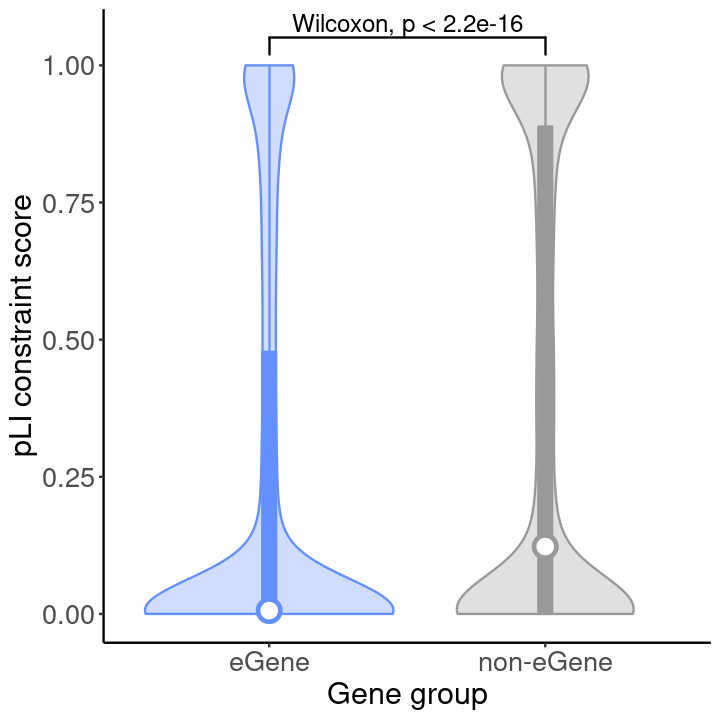

In [64]:
# modified boxplot, see ExAC original paper
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(fetal2, aes(x = sig, y = pLI, fill = sig, color = sig)) +
    geom_violin(alpha = 0.3, trim = TRUE) +
    geom_boxplot(width = 0.05) +
    labs(x = "Gene group", y = "pLI constraint score") + 
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.position = "none") +
    scale_fill_manual(values = c("#648FFF", "#999999")) +
    scale_color_manual(values = c("#648FFF", "#999999")) +
    stat_summary(fun.y = median, geom = "point", 
                 shape = 21, size = 5, show_guide = FALSE, fill = "white", stroke = 1.5) +
    geom_signif(
        comparisons = list(c("eGene", "non-eGene")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 5,
        color = "black"
  )

In [65]:
ggsave("../figures/pLI_fetal.pdf", width = 6, height = 6)

In [60]:
max(fetal2$pLI, na.rm = TRUE)

[1] 1

In [61]:
wilcox.test(fetal2[fetal2$sig == "eGene",'pLI'], fetal2[fetal2$sig == "non-eGene",'pLI'], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  fetal2[fetal2$sig == "eGene", "pLI"] and fetal2[fetal2$sig == "non-eGene", "pLI"]
W = 19334418, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [62]:
wilcox.test(fetal2[fetal2$sig == "eGene",'pLI'], fetal2[fetal2$sig == "non-eGene",'pLI'])


	Wilcoxon rank sum test with continuity correction

data:  fetal2[fetal2$sig == "eGene", "pLI"] and fetal2[fetal2$sig == "non-eGene", "pLI"]
W = 19334418, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


### Tri1 vs tri2 eGenes

In [22]:
tri1 <- read.table("../results/eur_trimester/sig_pheno_trimester1.txt", header = T)
tri2 <- read.table("../results/eur_trimester/sig_pheno_trimester2.txt", header = T)

In [18]:
dim(tri1)
dim(tri2)

[1] 4211   13

[1] 2220   13

In [23]:
tri1 <- tri1 %>% inner_join(exac, by = c("pid" = "ensg"))
tri2 <- tri2 %>% inner_join(exac, by = c("pid" = "ensg"))
dim(tri1)
dim(tri2)

[1] 1887   16

[1] 1060   16

In [15]:
df <- rbind(tri1, tri2)
df$group <- c(rep("Tri1 eGenes", 1887), rep("Tri2 eGenes",1060))
df$group <- factor(df$group, levels = c("Tri1 eGenes", "Tri2 eGenes"))

In [18]:
median(tri1$pLI)
median(tri2$pLI)

[1] 0.001392807

[1] 0.001578869

In [16]:
wilcox.test(df[df$group == "Tri1 eGenes",'pLI'], df[df$group == "Tri2 eGenes",'pLI'], two.sided = TRUE)


	Wilcoxon rank sum test with continuity correction

data:  df[df$group == "Tri1 eGenes", "pLI"] and df[df$group == "Tri2 eGenes", "pLI"]
W = 994095, p-value = 0.7861
alternative hypothesis: true location shift is not equal to 0


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”


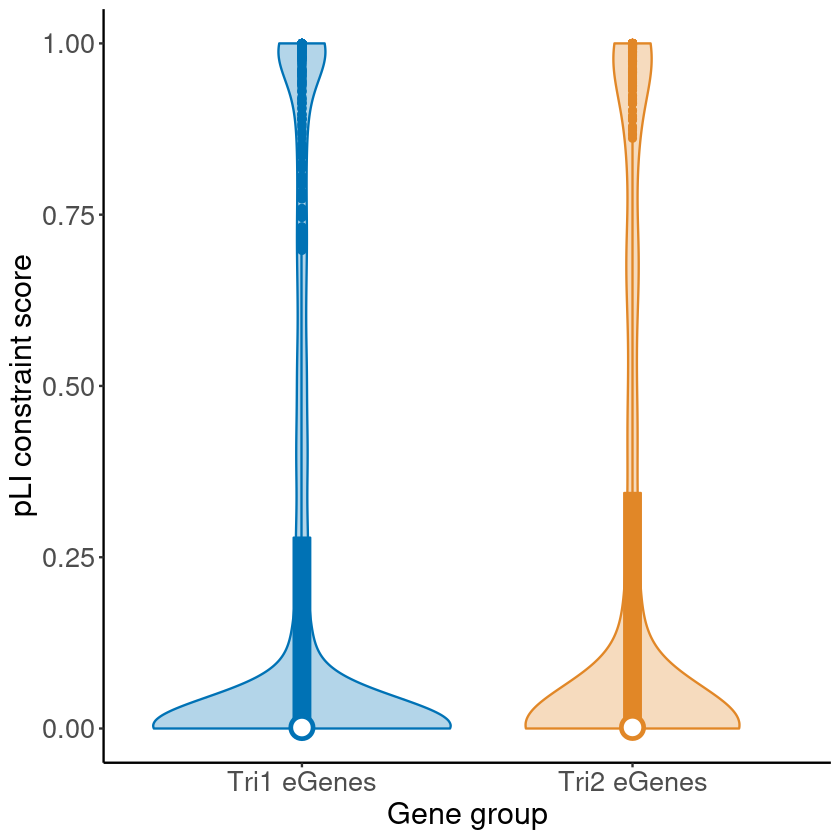

In [17]:
ggplot(df, aes(x = group, y = pLI, fill = group, color = group)) +
geom_violin(alpha = 0.3, trim = TRUE) +
geom_boxplot(width = 0.05) +
labs(x = "Gene group", y = "pLI constraint score") + 
theme_classic() +
theme(axis.text = element_text(size = 16),
      axis.title = element_text(size = 18),
      legend.position = "none") +
scale_fill_manual(values = c("#0072B5FF", "#E18727FF")) +
scale_color_manual(values = c("#0072B5FF", "#E18727FF")) +
stat_summary(fun.y = median, geom = "point", 
             shape = 21, size = 5, show_guide = FALSE, fill = "white", stroke = 1.5) 
# geom_signif(
#         comparisons = list(c("Fetal eGene", "Shared")),
#         annotation = "Wilcoxon, p < 2.2e-16",
#         textsize = 6,
#         color = "black"
#   )

In [24]:
tri1_only <- tri1 %>% filter(!pid %in% tri2$pid)
tri2_only <- tri2 %>% filter(!pid %in% tri1$pid)

In [26]:
dim(tri1_only)
dim(tri2_only)

[1] 1338   16

[1] 511  16

In [27]:
df <- rbind(tri1_only, tri2_only)
df$group <- c(rep("Tri1 only eGenes", 1338), rep("Tri2 only eGenes",511))
df$group <- factor(df$group, levels = c("Tri1 only eGenes", "Tri2 only eGenes"))

wilcox.test(df[df$group == "Tri1 only eGenes",'pLI'], df[df$group == "Tri2 only eGenes",'pLI'], two.sided = TRUE)


	Wilcoxon rank sum test with continuity correction

data:  df[df$group == "Tri1 only eGenes", "pLI"] and df[df$group == "Tri2 only eGenes", "pLI"]
W = 307853, p-value = 0.0009257
alternative hypothesis: true location shift is not equal to 0


Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”


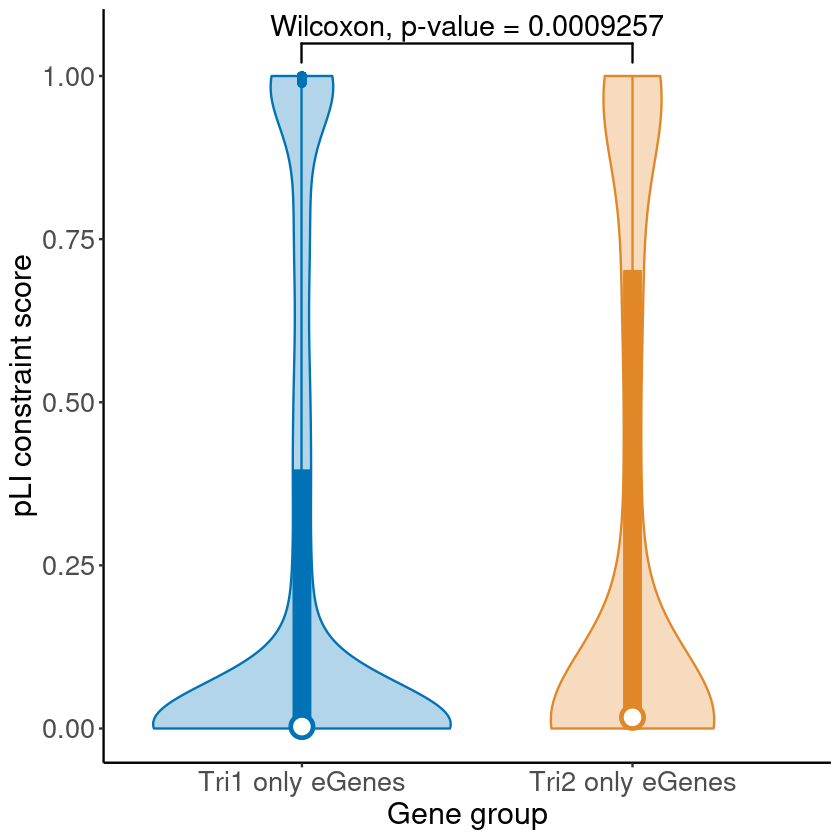

In [29]:
ggplot(df, aes(x = group, y = pLI, fill = group, color = group)) +
geom_violin(alpha = 0.3, trim = TRUE) +
geom_boxplot(width = 0.05) +
labs(x = "Gene group", y = "pLI constraint score") + 
theme_classic() +
theme(axis.text = element_text(size = 16),
      axis.title = element_text(size = 18),
      legend.position = "none") +
scale_fill_manual(values = c("#0072B5FF", "#E18727FF")) +
scale_color_manual(values = c("#0072B5FF", "#E18727FF")) +
stat_summary(fun = median, geom = "point", 
             shape = 21, size = 5, show_guide = FALSE, fill = "white", stroke = 1.5) +
geom_signif(
        comparisons = list(c("Tri1 only eGenes", "Tri2 only eGenes")),
        annotation = "Wilcoxon, p-value = 0.0009257",
        textsize = 6,
        color = "black"
  )

In [31]:
ggsave("../figures/pLI_tri_egene.pdf", width = 6, height = 6)

### e/iso/sGenes

In [20]:
egene <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", data.table = F)
isogene <- fread("~/project-gandalm/isoform_twas/isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
sgene <- fread("~/project-gandalm/isoform_twas/sqtl_new/results/mixed_grp_perm_40hcp_1e6/group.perm.genes.txt.gz", data.table = F)

isogene <- isogene %>% filter(qval < 0.05)
sgene <- sgene %>% filter(qval < 0.05)
sgene <- sgene %>% separate(group_id, c("ensg_id", "version"), sep = "[.]", remove = FALSE)

In [21]:
egene$Group <- "eGene"
isogene$Group <- "isoGene"
sgene$Group <- "sGene"

In [22]:
dim(egene)
length(unique(egene$pid))
dim(isogene)
length(unique(isogene$group_id))
dim(sgene)
length(unique(sgene$ensg_id))

[1] 10094    14

[1] 10094

[1] 11861    22

[1] 11845

[1] 8191   24

[1] 7490

In [23]:
length(unique(sgene$group_id))

[1] 7490

In [24]:
egene <- egene %>% select(pid, Group)
egene <- egene[!duplicated(egene),]
isogene <- isogene %>% select(group_id, Group)
isogene <- isogene[!duplicated(isogene),]
sgene <- sgene %>% select(ensg_id, Group)
sgene <- sgene[!duplicated(sgene),]

In [25]:
dim(egene)
dim(isogene)
dim(sgene)

[1] 10094     2

[1] 11845     2

[1] 7490    2

In [26]:
egene <- egene %>% inner_join(exac, by = c("pid" = "ensg"))
dim(egene)
isogene <- isogene %>% inner_join(exac, by = c("group_id" = "ensg"))
dim(isogene)
sgene <- sgene %>% inner_join(exac, by = c("ensg_id" = "ensg"))
dim(sgene)

[1] 5528    5

[1] 6838    5

[1] 5286    5

In [28]:
colnames(isogene)[1] <- "pid"
colnames(sgene)[1] <- "pid"
df <- rbind(egene, isogene, sgene)

In [29]:
df$Group <- factor(df$Group, levels = c("eGene", "isoGene", "sGene"))

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


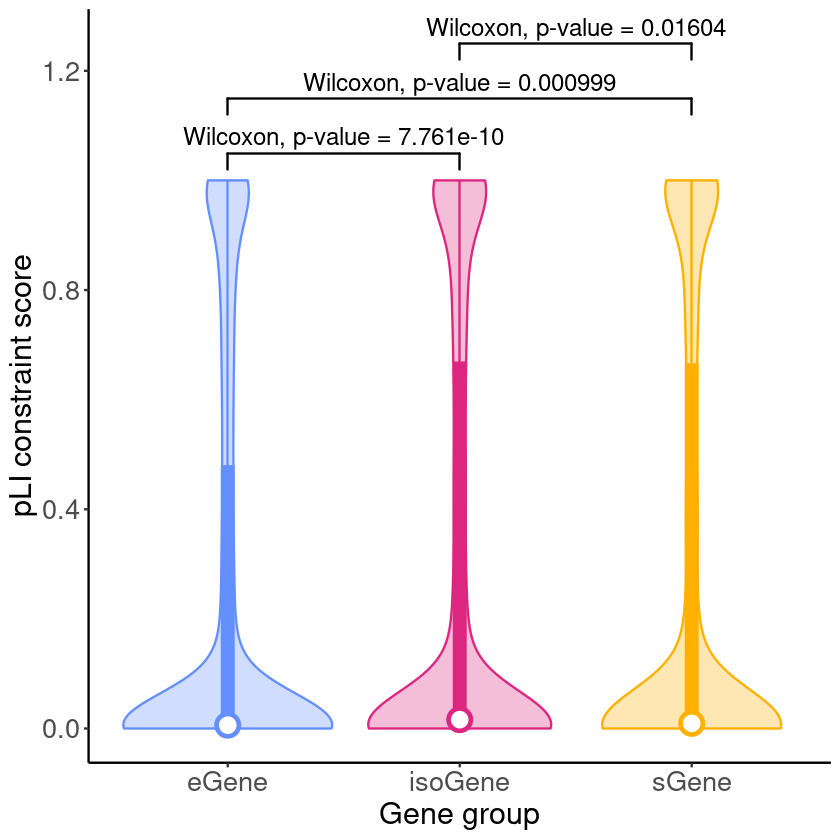

In [41]:
ggplot(df, aes(x = Group, y = pLI, fill = Group, color = Group)) +
    geom_violin(alpha = 0.3, trim = TRUE) +
    geom_boxplot(width = 0.05) +
    labs(x = "Gene group", y = "pLI constraint score") + 
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.position = "none") +
    scale_fill_manual(values = c("#648FFF", "#DC267F", "#FFB000")) +
    scale_color_manual(values = c("#648FFF", "#DC267F", "#FFB000")) +
    stat_summary(fun.y = median, geom = "point", 
                 shape = 21, size = 5, show.legend = FALSE, fill = "white", stroke = 1.5) +
    geom_signif(
        comparisons = list(c("eGene", "isoGene"), c("eGene", "sGene"), c("isoGene", "sGene")),
        annotation = c("Wilcoxon, p-value = 7.761e-10", 
                       "Wilcoxon, p-value = 0.000999",
                       "Wilcoxon, p-value = 0.01604"),
        textsize = 5,
        color = "black",
        step_increase = 0.1
    )

In [33]:
wilcox.test(df[df$Group == "eGene",'pLI'], df[df$Group == "isoGene",'pLI'], two.sided = TRUE)
wilcox.test(df[df$Group == "eGene",'pLI'], df[df$Group == "sGene",'pLI'], two.sided = TRUE)
wilcox.test(df[df$Group == "sGene",'pLI'], df[df$Group == "isoGene",'pLI'], two.sided = TRUE)


	Wilcoxon rank sum test with continuity correction

data:  df[df$Group == "eGene", "pLI"] and df[df$Group == "isoGene", "pLI"]
W = 17686434, p-value = 7.761e-10
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  df[df$Group == "eGene", "pLI"] and df[df$Group == "sGene", "pLI"]
W = 14076466, p-value = 0.000999
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  df[df$Group == "sGene", "pLI"] and df[df$Group == "isoGene", "pLI"]
W = 17612638, p-value = 0.01604
alternative hypothesis: true location shift is not equal to 0


In [42]:
ggsave("../figures/pLI_e_iso_sGene.pdf", height = 6, width = 6)